LTV PREDICTION ANALYSIS - SHIFTED GOMPERTZ CURVE — Hanna Todorova

1. ПІДГОТОВКА ДАНИХ
--------------------------------------------------------------------------------
Загальна кількість транзакцій: 6,086
Кількість унікальних користувачів: 934
Період даних: 2023-02-26 00:00:00 - 2023-10-08 00:00:00
Максимальний lifetime_weeks: 32


2. РОЗРАХУНОК ФАКТИЧНОГО LTV (КУМУЛЯТИВНИЙ)
--------------------------------------------------------------------------------

Приклад фактичного LTV (перша когорта, перші 8 тижнів):
 lifetime_weeks     ltv  active_users  retention
              0  2.4900            20       1.00
              1  3.9840            12       0.60
              2  5.2290            10       0.50
              3  6.4740            10       0.50
              4  7.4700             8       0.40
              5  8.3415             7       0.35
              6  9.2130             4       0.20
              7 10.2090             7       0.35


3. МЕТОД ПРОГНОЗУВАННЯ
------------------

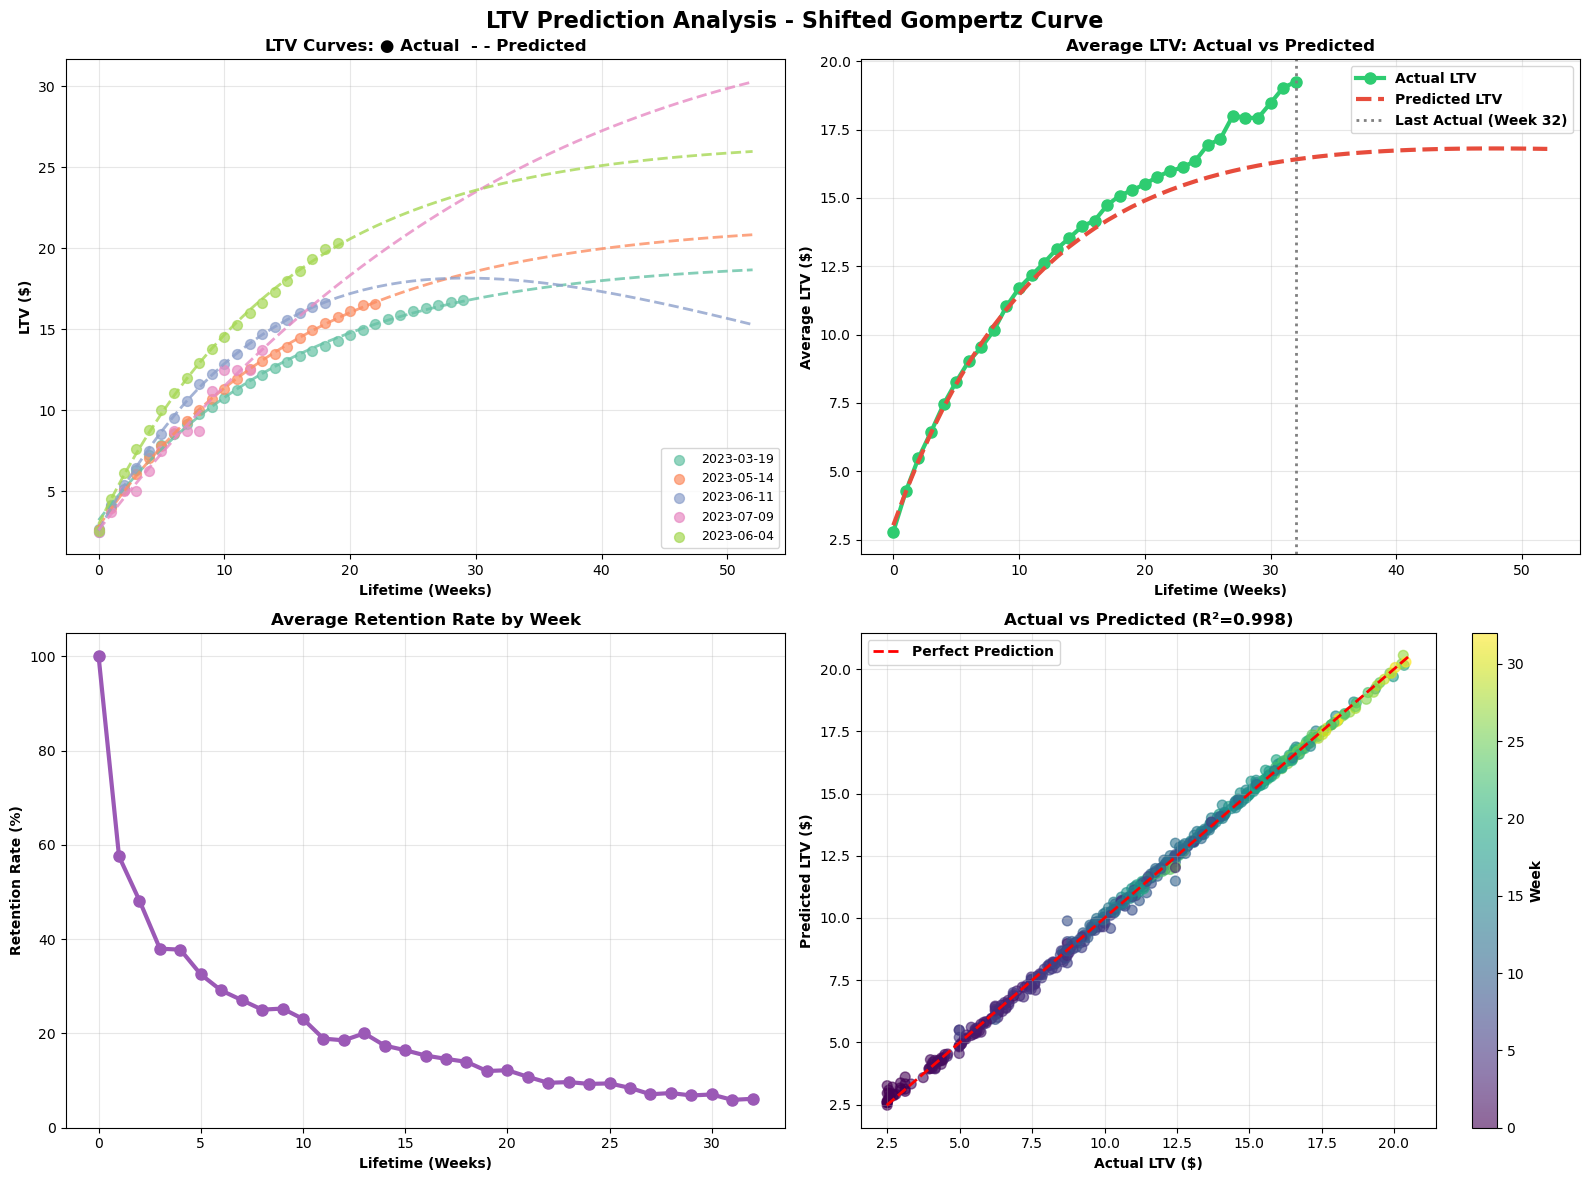



7. ПРОГНОЗ LTV НА 52 ТИЖНІ
--------------------------------------------------------------------------------

Прогноз на 52 тижні:
  Середній LTV: $16.79
  Медіанний LTV: $18.08
  Діапазон LTV: $5.25 - $30.28
  Прогнозний сукупний дохід: $16,680.00

Порівняння:
  Останній фактичний LTV (тиждень 16): $14.17
  Очікуваний приріст: $2.63 (+18.5%)
  Модель передбачає вихід на плато


8. ЗБЕРЕЖЕННЯ У HTML
--------------------------------------------------------------------------------
HTML звіт збережено: ltv_prediction_report_2.html

Для перегляду відкрийте файл ltv_prediction_report_2.html у браузері



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore')

# ЗАВАНТАЖЕННЯ ДАНИХ
df = pd.read_csv(r'C:\Users\user\Downloads\KMA TestTask Product Analyst - Task2.csv')

print("="*80)
print("LTV PREDICTION ANALYSIS - SHIFTED GOMPERTZ CURVE — Hanna Todorova")
print("="*80)

# 1. ПІДГОТОВКА ДАНИХ
print("\n1. ПІДГОТОВКА ДАНИХ")
print("-"*80)

df['event_timestamp'] = pd.to_datetime(df['event_timestamp'])
df['first_purchase_time'] = pd.to_datetime(df['first_purchase_time'])
df['cohort_week'] = pd.to_datetime(df['cohort_week'])
df['price'] = df['product_id'].str.extract(r'(\d+\.?\d*)').astype(float)

print(f"Загальна кількість транзакцій: {len(df):,}")
print(f"Кількість унікальних користувачів: {df['user_id'].nunique():,}")
print(f"Період даних: {df['cohort_week'].min()} - {df['cohort_week'].max()}")
print(f"Максимальний lifetime_weeks: {df['lifetime_weeks'].max()}")

# 2. РОЗРАХУНОК ФАКТИЧНОГО LTV
print("\n\n2. РОЗРАХУНОК ФАКТИЧНОГО LTV (КУМУЛЯТИВНИЙ)")
print("-"*80)

ltv_data = []

for cohort in df['cohort_week'].unique():
    cohort_users = df[df['cohort_week'] == cohort]
    cohort_size = cohort_users['user_id'].nunique()
    
    for week in range(int(cohort_users['lifetime_weeks'].max()) + 1):
        revenue_until_week = cohort_users[cohort_users['lifetime_weeks'] <= week]['price'].sum()
        active_users = cohort_users[cohort_users['lifetime_weeks'] == week]['user_id'].nunique()
        
        ltv_data.append({
            'cohort_week': cohort,
            'lifetime_weeks': week,
            'cohort_size': cohort_size,
            'cumulative_revenue': revenue_until_week,
            'ltv': revenue_until_week / cohort_size,
            'active_users': active_users,
            'retention': active_users / cohort_size if cohort_size > 0 else 0
        })

ltv_df = pd.DataFrame(ltv_data)

print("\nПриклад фактичного LTV (перша когорта, перші 8 тижнів):")
sample_cohort = ltv_df['cohort_week'].min()
sample_data = ltv_df[ltv_df['cohort_week'] == sample_cohort].head(8)
print(sample_data[['lifetime_weeks', 'ltv', 'active_users', 'retention']].to_string(index=False))

# 3. SHIFTED GOMPERTZ CURVE
print("\n\n3. МЕТОД ПРОГНОЗУВАННЯ")
print("-"*80)
print("Обраний підхід: Shifted Gompertz Curve")
print("Формула: LTV(t) = a * (1 - exp(-b * t)) * exp(-c * t) + d")
print("\nОбґрунтування:")
print("- Моделює S-подібну криву з виходом на плато")
print("- Враховує швидке зростання на початку та уповільнення пізніше")
print("- Реалістично відображає поведінку з churn")

def shifted_gompertz(t, a, b, c, d):
    """Shifted Gompertz curve"""
    return a * (1 - np.exp(-b * t)) * np.exp(-c * t) + d

# 4. ТРЕНУВАННЯ МОДЕЛІ
print("\n\n4. ПОБУДОВА МОДЕЛІ")
print("-"*80)

predictions = []
min_weeks_for_training = 6
model_params = {}

for cohort in ltv_df['cohort_week'].unique():
    cohort_data = ltv_df[ltv_df['cohort_week'] == cohort].copy()
    cohort_data = cohort_data.sort_values('lifetime_weeks')
    max_week = cohort_data['lifetime_weeks'].max()
    
    if max_week >= min_weeks_for_training:
        X = cohort_data['lifetime_weeks'].values
        y = cohort_data['ltv'].values
        
        try:
            params, _ = curve_fit(
                shifted_gompertz, 
                X, y,
                p0=[y.max(), 0.1, 0.01, 0],
                maxfev=10000,
                bounds=([0, 0, 0, -np.inf], [np.inf, 1, 1, np.inf])
            )
            
            model_params[cohort] = params
            
            weeks_predict = np.arange(0, 53)
            ltv_predict = shifted_gompertz(weeks_predict, *params)
            
            for week in weeks_predict:
                pred_record = {
                    'cohort_week': cohort,
                    'lifetime_weeks': week,
                    'ltv_predicted': ltv_predict[week],
                    'cohort_size': cohort_data['cohort_size'].iloc[0]
                }
                
                actual_row = cohort_data[cohort_data['lifetime_weeks'] == week]
                if not actual_row.empty:
                    pred_record['ltv_actual'] = actual_row['ltv'].values[0]
                    pred_record['retention_actual'] = actual_row['retention'].values[0]
                else:
                    pred_record['ltv_actual'] = np.nan
                    pred_record['retention_actual'] = np.nan
                
                predictions.append(pred_record)
                
        except Exception as e:
            print(f"Помилка для когорти {cohort.strftime('%Y-%m-%d')}: {e}")

predictions_df = pd.DataFrame(predictions)
print(f"\nКількість когорт з моделями: {len(model_params)}")
print(f"Прогноз побудовано до {predictions_df['lifetime_weeks'].max()} тижнів")

# 5. ОЦІНКА ЯКОСТІ
print("\n\n5. ОЦІНКА ЯКОСТІ МОДЕЛІ")
print("-"*80)

validation_data = predictions_df[predictions_df['ltv_actual'].notna()].copy()
mae = rmse = r2 = mape = 0

if len(validation_data) > 0:
    mae = mean_absolute_error(validation_data['ltv_actual'], validation_data['ltv_predicted'])
    rmse = np.sqrt(mean_squared_error(validation_data['ltv_actual'], validation_data['ltv_predicted']))
    r2 = r2_score(validation_data['ltv_actual'], validation_data['ltv_predicted'])
    
    non_zero = validation_data[validation_data['ltv_actual'] > 0]
    if len(non_zero) > 0:
        mape = np.mean(np.abs((non_zero['ltv_actual'] - non_zero['ltv_predicted']) / 
                              non_zero['ltv_actual'])) * 100
    
    print(f"Mean Absolute Error (MAE): ${mae:.2f}")
    print(f"Root Mean Square Error (RMSE): ${rmse:.2f}")
    print(f"R² Score: {r2:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    
    if r2 > 0.9:
        print("\n✓ ВІДМІННА якість моделі (R² > 0.9)")
    elif r2 > 0.8:
        print("\n✓ ХОРОША якість моделі (R² > 0.8)")
    elif r2 > 0.7:
        print("\n⚡ ЗАДОВІЛЬНА якість моделі (R² > 0.7)")
    else:
        print("\n⚠️ НИЗЬКА якість моделі (R² < 0.7)")

# 6. ВІЗУАЛІЗАЦІЯ
print("\n\n6. ВІЗУАЛІЗАЦІЯ")
print("-"*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('LTV Prediction Analysis - Shifted Gompertz Curve', fontsize=16, fontweight='bold')

# 6.1. LTV кривих по когортах
ax1 = axes[0, 0]
cohorts_to_plot = predictions_df['cohort_week'].unique()[:5]

for i, cohort in enumerate(cohorts_to_plot):
    cohort_pred = predictions_df[predictions_df['cohort_week'] == cohort]
    actual_data = cohort_pred[cohort_pred['ltv_actual'].notna()]
    
    color = plt.cm.Set2(i)
    ax1.scatter(actual_data['lifetime_weeks'], actual_data['ltv_actual'], 
               alpha=0.7, s=50, color=color, label=f'{cohort.strftime("%Y-%m-%d")}')
    ax1.plot(cohort_pred['lifetime_weeks'], cohort_pred['ltv_predicted'], 
            '--', alpha=0.8, linewidth=2, color=color)

ax1.set_xlabel('Lifetime (Weeks)', fontweight='bold')
ax1.set_ylabel('LTV ($)', fontweight='bold')
ax1.set_title('LTV Curves: ● Actual  - - Predicted', fontweight='bold')
ax1.legend(fontsize=9, loc='lower right')
ax1.grid(True, alpha=0.3)

# 6.2. Середній LTV
ax2 = axes[0, 1]
avg_actual = predictions_df.groupby('lifetime_weeks')['ltv_actual'].mean()
avg_predicted = predictions_df.groupby('lifetime_weeks')['ltv_predicted'].mean()

weeks_actual = avg_actual.dropna().index
ax2.plot(weeks_actual, avg_actual.loc[weeks_actual], 
        'o-', linewidth=3, markersize=8, label='Actual LTV', color='#2ecc71')
ax2.plot(avg_predicted.index, avg_predicted.values, 
        '--', linewidth=3, label='Predicted LTV', color='#e74c3c')

if len(weeks_actual) > 0:
    ax2.axvline(x=weeks_actual.max(), color='gray', linestyle=':', 
               label=f'Last Actual (Week {int(weeks_actual.max())})', linewidth=2)

ax2.set_xlabel('Lifetime (Weeks)', fontweight='bold')
ax2.set_ylabel('Average LTV ($)', fontweight='bold')
ax2.set_title('Average LTV: Actual vs Predicted', fontweight='bold')
legend = ax2.legend()
for text in legend.get_texts():
    text.set_fontweight('bold')
ax2.grid(True, alpha=0.3)

# 6.3. Retention curve
ax3 = axes[1, 0]
retention_by_week = ltv_df.groupby('lifetime_weeks')['retention'].mean() * 100

ax3.plot(retention_by_week.index, retention_by_week.values, 
        'o-', linewidth=3, markersize=8, color='#9b59b6')
ax3.set_xlabel('Lifetime (Weeks)', fontweight='bold')
ax3.set_ylabel('Retention Rate (%)', fontweight='bold')
ax3.set_title('Average Retention Rate by Week', fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.set_ylim(0, 105)

# 6.4. Actual vs Predicted
ax4 = axes[1, 1]
if len(validation_data) > 0:
    scatter = ax4.scatter(validation_data['ltv_actual'], 
                         validation_data['ltv_predicted'], 
                         c=validation_data['lifetime_weeks'],
                         alpha=0.6, s=50, cmap='viridis')
    
    min_val = min(validation_data['ltv_actual'].min(), validation_data['ltv_predicted'].min())
    max_val = max(validation_data['ltv_actual'].max(), validation_data['ltv_predicted'].max())
    ax4.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    
    ax4.set_xlabel('Actual LTV ($)', fontweight='bold')
    ax4.set_ylabel('Predicted LTV ($)', fontweight='bold')
    ax4.set_title(f'Actual vs Predicted (R²={r2:.3f})', fontweight='bold')
    
    cbar = plt.colorbar(scatter, ax=ax4)
    cbar.set_label('Week', fontweight='bold')
    legend = ax4.legend()
    for text in legend.get_texts():
        text.set_fontweight('bold')
    ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ltv_analysis_charts.png', dpi=150, bbox_inches='tight')
print("Графіки збережено: ltv_analysis_charts.png")
plt.show()

# 7. ПРОГНОЗ НА 52 ТИЖНІ
print("\n\n7. ПРОГНОЗ LTV НА 52 ТИЖНІ")
print("-"*80)

week_52_data = predictions_df[predictions_df['lifetime_weeks'] == 52]
ltv_52 = week_52_data.groupby('cohort_week')['ltv_predicted'].mean()
total_revenue_52 = (week_52_data['ltv_predicted'] * week_52_data['cohort_size']).sum()

print(f"\nПрогноз на 52 тижні:")
print(f"  Середній LTV: ${ltv_52.mean():.2f}")
print(f"  Медіанний LTV: ${ltv_52.median():.2f}")
print(f"  Діапазон LTV: ${ltv_52.min():.2f} - ${ltv_52.max():.2f}")
print(f"  Прогнозний сукупний дохід: ${total_revenue_52:,.2f}")

last_week = predictions_df['ltv_actual'].last_valid_index()
growth_expected = 0

if last_week is not None:
    last_week_num = predictions_df.loc[last_week, 'lifetime_weeks']
    avg_last_ltv = predictions_df[predictions_df['lifetime_weeks'] == last_week_num]['ltv_actual'].mean()
    growth_expected = ((ltv_52.mean() - avg_last_ltv) / avg_last_ltv) * 100
    
    print(f"\nПорівняння:")
    print(f"  Останній фактичний LTV (тиждень {int(last_week_num)}): ${avg_last_ltv:.2f}")
    print(f"  Очікуваний приріст: ${ltv_52.mean() - avg_last_ltv:.2f} ({growth_expected:+.1f}%)")
    print(f"  Модель передбачає {'вихід на плато' if growth_expected < 30 else 'помірне зростання'}")

# 8. HTML ЗВІТ
print("\n\n8. ЗБЕРЕЖЕННЯ У HTML")
print("-"*80)

quality_class = 'quality-excellent' if r2 > 0.9 else 'quality-good' if r2 > 0.8 else 'quality-fair' if r2 > 0.7 else 'quality-poor'
quality_text = 'ВІДМІННА' if r2 > 0.9 else 'ХОРОША' if r2 > 0.8 else 'ЗАДОВІЛЬНА' if r2 > 0.7 else 'НИЗЬКА'

html_content = f"""<!DOCTYPE html>
<html lang="uk">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>LTV Prediction Analysis - Shifted Gompertz — Hanna Todorova</title>
    <style>
        body {{ font-family: Arial, sans-serif; margin: 20px; background-color: #f5f5f5; }}
        .container {{ max-width: 1400px; margin: 0 auto; background-color: white; padding: 30px; box-shadow: 0 0 10px rgba(0,0,0,0.1); }}
        h1 {{ color: #2c3e50; border-bottom: 3px solid #3498db; padding-bottom: 10px; }}
        h2 {{ color: #34495e; margin-top: 30px; border-left: 4px solid #3498db; padding-left: 10px; }}
        h3 {{ color: #34495e; margin-top: 20px; }}
        table {{ border-collapse: collapse; width: 100%; margin: 20px 0; font-size: 14px; }}
        th, td {{ border: 1px solid #ddd; padding: 12px; text-align: left; }}
        th {{ background-color: #3498db; color: white; font-weight: bold; }}
        tr:nth-child(even) {{ background-color: #f9f9f9; }}
        .metric {{ display: inline-block; margin: 10px 20px 10px 0; padding: 15px; background-color: #ecf0f1; border-radius: 5px; min-width: 200px; }}
        .metric-label {{ font-weight: bold; color: #7f8c8d; font-size: 14px; }}
        .metric-value {{ font-size: 24px; color: #2c3e50; margin-top: 5px; }}
        .quality-excellent {{ color: #27ae60; font-weight: bold; }}
        .quality-good {{ color: #2ecc71; font-weight: bold; }}
        .quality-fair {{ color: #f39c12; font-weight: bold; }}
        .quality-poor {{ color: #e74c3c; font-weight: bold; }}
        img {{ max-width: 100%; height: auto; margin: 20px 0; border: 1px solid #ddd; }}
        .info-box {{ background-color: #e3f2fd; border-left: 5px solid #2196f3; padding: 15px; margin: 20px 0; }}
        .method-box {{ background-color: #f3e5f5; border-left: 5px solid #9c27b0; padding: 15px; margin: 20px 0; }}
        .warning-box {{ background-color: #fff3cd; border-left: 5px solid #ffc107; padding: 15px; margin: 20px 0; }}
        .formula {{ background-color: #f8f9fa; padding: 10px; border-radius: 5px; font-family: 'Courier New', monospace; font-size: 14px; margin: 10px 0; text-align: center; }}
        ul {{ line-height: 1.8; }}
        .highlight {{ background-color: #fff9c4; padding: 2px 5px; border-radius: 3px; }}
    </style>
</head>
<body>
    <div class="container">
        <h1>📊 LTV Prediction Analysis - Shifted Gompertz Curve — Hanna Todorova</h1>
        <p><strong>Дата аналізу:</strong> {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}</p>
        
        <div class="warning-box">
            <h4>📈 Shifted Gompertz Curve для прогнозування LTV</h4>
            <p>Ця модель передбачає:</p>
            <ul>
                <li><strong>S-подібну криву</strong> - швидке зростання на початку, потім уповільнення</li>
                <li><strong>Вихід на плато</strong> - LTV стабілізується через churn</li>
                <li><strong>Реалістичну поведінку</strong> - відображає справжні патерни retention</li>
            </ul>
        </div>
        
        <h2>1. Загальна інформація</h2>
        <div class="metric">
            <div class="metric-label">Транзакцій</div>
            <div class="metric-value">{len(df):,}</div>
        </div>
        <div class="metric">
            <div class="metric-label">Користувачів</div>
            <div class="metric-value">{df['user_id'].nunique():,}</div>
        </div>
        <div class="metric">
            <div class="metric-label">Когорт</div>
            <div class="metric-value">{df['cohort_week'].nunique()}</div>
        </div>
        
        <h2>2. Метод прогнозування</h2>
        <div class="method-box">
            <h3>🔬 Shifted Gompertz Curve</h3>
            <div class="formula">LTV(t) = a × (1 - e<sup>-b×t</sup>) × e<sup>-c×t</sup> + d</div>
            <p><strong>Параметри моделі:</strong></p>
            <ul>
                <li><strong>a</strong> - максимальний потенційний LTV (плато)</li>
                <li><strong>b</strong> - швидкість початкового зростання</li>
                <li><strong>c</strong> - швидкість виходу на плато (churn rate)</li>
                <li><strong>d</strong> - базове зміщення</li>
            </ul>
        </div>
        
        <h3>Параметри моделей по когортах (топ 10)</h3>
        <table>
            <tr>
                <th>Когорта</th>
                <th>a (плато)</th>
                <th>b (зростання)</th>
                <th>c (churn)</th>
                <th>d (база)</th>
            </tr>
"""

for i, (cohort, params) in enumerate(list(model_params.items())[:10]):
    html_content += f"""
            <tr>
                <td>{cohort.strftime('%Y-%m-%d')}</td>
                <td>{params[0]:.2f}</td>
                <td>{params[1]:.4f}</td>
                <td>{params[2]:.4f}</td>
                <td>{params[3]:.2f}</td>
            </tr>
"""

html_content += f"""
        </table>
        
        <h2>3. Якість моделі</h2>
        <table>
            <tr>
                <th>Метрика</th>
                <th>Значення</th>
                <th>Опис</th>
            </tr>
            <tr>
                <td><strong>R² Score</strong></td>
                <td class="{quality_class}">{r2:.4f}</td>
                <td>Коефіцієнт детермінації</td>
            </tr>
            <tr>
                <td><strong>MAE</strong></td>
                <td>${mae:.2f}</td>
                <td>Середня абсолютна помилка</td>
            </tr>
            <tr>
                <td><strong>RMSE</strong></td>
                <td>${rmse:.2f}</td>
                <td>Корінь середньоквадратичної помилки</td>
            </tr>
            <tr>
                <td><strong>MAPE</strong></td>
                <td>{mape:.2f}%</td>
                <td>Середня абсолютна процентна помилка</td>
            </tr>
        </table>
        
        <div class="info-box">
            <h4 class="{quality_class}">✓ {quality_text} ЯКІСТЬ МОДЕЛІ (R² = {r2:.4f})</h4>
            <p>Модель пояснює {r2*100:.1f}% варіації в даних LTV.</p>
        </div>
        
        <h2>4. Прогноз LTV на 52 тижні</h2>
        <div class="metric">
            <div class="metric-label">Середній LTV (52 тижні)</div>
            <div class="metric-value">${ltv_52.mean():.2f}</div>
        </div>
        <div class="metric">
            <div class="metric-label">Медіанний LTV</div>
            <div class="metric-value">${ltv_52.median():.2f}</div>
        </div>
        <div class="metric">
            <div class="metric-label">Діапазон LTV</div>
            <div class="metric-value">${ltv_52.min():.2f} - ${ltv_52.max():.2f}</div>
        </div>
        <div class="metric">
            <div class="metric-label">Прогнозний сукупний дохід</div>
            <div class="metric-value">${total_revenue_52:,.0f}</div>
        </div>
"""

if last_week is not None:
    html_content += f"""
        <div class="info-box">
            <h4>📊 Порівняння з фактичними даними</h4>
            <p><strong>Останній фактичний LTV (тиждень {int(last_week_num)}):</strong> ${avg_last_ltv:.2f}</p>
            <p><strong>Прогноз на 52 тижні:</strong> ${ltv_52.mean():.2f}</p>
            <p><strong>Очікуваний приріст:</strong> ${ltv_52.mean() - avg_last_ltv:.2f} (<span class="highlight">{growth_expected:+.1f}%</span>)</p>
            <p><strong>Інтерпретація:</strong> Модель передбачає {'вихід на плато' if growth_expected < 30 else 'помірне зростання'}</p>
        </div>
"""

cohort_predictions = week_52_data.groupby('cohort_week').agg({
    'ltv_predicted': 'mean',
    'cohort_size': 'first'
}).reset_index()
cohort_predictions['total_revenue'] = cohort_predictions['ltv_predicted'] * cohort_predictions['cohort_size']
cohort_predictions = cohort_predictions.sort_values('cohort_week')

html_content += f"""
        <h3>Прогноз по когортах (52 тижні)</h3>
        <table>
            <tr>
                <th>Когорта</th>
                <th>Розмір</th>
                <th>LTV (52 тижні)</th>
                <th>Сукупний revenue</th>
            </tr>
"""

for _, row in cohort_predictions.head(15).iterrows():
    html_content += f"""
            <tr>
                <td>{row['cohort_week'].strftime('%Y-%m-%d')}</td>
                <td>{int(row['cohort_size']):,}</td>
                <td>${row['ltv_predicted']:.2f}</td>
                <td>${row['total_revenue']:,.0f}</td>
            </tr>
"""

html_content += f"""
        </table>
        
        <h2>5. Візуалізація</h2>
        <img src="ltv_analysis_charts.png" alt="LTV Analysis Charts">
        
        <h2>6. Висновки</h2>
        <div class="info-box">
            <h4>🎓 Ключові висновки:</h4>
            <ul>
                <li>Модель <strong>Shifted Gompertz Curve</strong> досягла якості R² = {r2:.4f}</li>
                <li>Прогнозний LTV на рік: <strong>${ltv_52.mean():.2f}</strong></li>
                <li>Прогнозний сукупний дохід: <strong>${total_revenue_52:,.0f}</strong></li>
                <li>Модель враховує природний churn та вихід на плато</li>
            </ul>
            
            <h4>💡 Рекомендації:</h4>
            <ul>
                <li><strong>Покращити retention</strong> на ранніх тижнях через onboarding</li>
                <li><strong>Збільшити ARPU</strong> через upselling та premium features</li>
                <li><strong>Сегментація</strong> - окремі моделі для різних сегментів</li>
                <li><strong>Моніторинг</strong> - відстежувати LTV по когортах щотижня</li>
            </ul>
        </div>
    </div>
</body>
</html>
"""

with open('ltv_prediction_report_2.html', 'w', encoding='utf-8') as f:
    f.write(html_content)

print("HTML звіт збережено: ltv_prediction_report_2.html")
print("\nДля перегляду відкрийте файл ltv_prediction_report_2.html у браузері")
print("\n" + "="*80)